In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# WGAN

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *
import gzip
#torch.cuda.set_device(3)

C:\Users\ac32\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
'''
Download the LSUN scene classification dataset bedroom category, unzip it, and convert it to jpg files
(the scripts folder is here in the dl2 folder):

curl 'http://lsun.cs.princeton.edu/htbin/download.cgi?tag=latest&category=bedroom&set=train' -o bedroom.zip
unzip bedroom.zip
pip install lmdb
python lsun-data.py {PATH}/bedroom_train_lmdb --out_dir {PATH}/bedroom
This isn't tested on Windows - if it doesn't work, you could use a Linux box to convert the files, 
then copy them over. Alternatively, you can download this 20% sample from Kaggle datasets.
'''

"\nDownload the LSUN scene classification dataset bedroom category, unzip it, and convert it to jpg files\n(the scripts folder is here in the dl2 folder):\n\ncurl 'http://lsun.cs.princeton.edu/htbin/download.cgi?tag=latest&category=bedroom&set=train' -o bedroom.zip\nunzip bedroom.zip\npip install lmdb\npython lsun-data.py {PATH}/bedroom_train_lmdb --out_dir {PATH}/bedroom\nThis isn't tested on Windows - if it doesn't work, you could use a Linux box to convert the files, \nthen copy them over. Alternatively, you can download this 20% sample from Kaggle datasets.\n"

In [119]:
PATH = Path('C:/input/Fast_AI/lsun_bedroom/sample/data0/lsun/')
IMG_PATH = PATH/'bedroom'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [21]:
files = PATH.glob('bedroom/**/*.jpg') # 绝对文件名列表

In [22]:
with CSV_PATH.open('w') as fo: # 记录读取的文件名
    #for f in files: fo.write("{}.format(f.relative_to(IMG_PATH)),0\n")
    #for f in files: fo.write('f.relative_to(IMG_PATH),0\n')
    for f in files: fo.write("{},0\n".format(f.relative_to(IMG_PATH))) #相对路径的文件名,为什么要加0？为了label

In [25]:
# Optional - sampling a subset of files
CSV_PATH = PATH/'files_sample.csv'

In [27]:
files = PATH.glob('bedroom/**/*.jpg') # glob抓取全部文件
with CSV_PATH.open('w') as fo:
    for f in files:
        if random.random()<0.1: fo.write("{},0\n".format(f.relative_to(IMG_PATH))) # 10%的数据作为校验集

In [92]:
class ConvBlock(nn.Module): #卷积块
    def __init__(self,ni,no,ks,stride,bn=True,pad=None): # pad是每个边缘都补上
        super().__init__()
        if pad is None: pad = ks//2//stride # 增加 ks/stride个滑动，即增加这么多个长度
        self.conv = nn.Conv2d(ni,no,ks,stride,padding=pad,bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None #正则化
        self.relu = nn.LeakyReLU(0.2,inplace=True) # LeakyReLU激励
        
    def forward(self,x):
        x = self.relu(self.conv(x)) # 先卷积，再激励
        return self.bn(x) if self.bn else x # 最后BatchNorm2d

In [93]:
class DCGAN_D(nn.Module): # 鉴别器
    def __init__(self,isize,nc,ndf,n_extra_layers=0):
        super().__init__()
        assert isize % 16 ==0, "isize has to be a mutiple of 16" # %求余，必须被16整除掉
        self.initial = ConvBlock(nc,ndf,4,2,bn=False) # 初始nc->ndf
        csize,cndf = isize/2, ndf
        # Sequential:类似贯序模型，是Module的子类,有forward方法，ModuleList没有forward方法
        self.extra = nn.Sequential(*[ConvBlock(cndf,cndf,3,1) for t in range(n_extra_layers)]) #kernel一样多
        
        pyr_layers = [] #金字塔式卷积
        while csize >4: # csize初始化
            pyr_layers.append(ConvBlock(cndf,cndf*2,4,2)) # 图片越来越小，kernel叠加越来越高
            cndf *=2; csize /=2
        self.pyramid = nn.Sequential(*pyr_layers) # 追加卷积
        
        self.final = nn.Conv2d(cndf,1,4,padding=0,bias=False) # 最后一次卷积(一个通道，)
    
    def forward(self,input):
        x = self.initial(input)
        x = self.extra(x) # Sequential中层与层之间无需forward描述
        x = self.pyramid(x) # Sequential层
        return self.final(x).mean(0).view(1) #
        

In [94]:
class DeconvBlock(nn.Module): # 反卷积
    def __init__(self,ni,no,ks,stride,pad,bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni,no,ks,stride,padding=pad, bias=False) # 反卷积
        self.bn = nn.BatchNorm2d(no) # 批量正则化
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self,x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x
        

In [95]:
class DCGAN_G(nn.Module): # 生成器
    def __init__(self,isize,nz,nc,nfg,n_extra_layers=0): #nz起始输入，nc起始输出,(isize=64,nz=100,nc=3,nfg=64,extra=1)
        super().__init__()
        assert isize %16 ==0, "isize has to be a multiple of 16"
        
        cngf, tisize = nfg//2, 4  # 例子中cngf=32,tisize=4
        while tisize!=isize: cngf*=2; tisize *=2 # 32*4=
        layers = [DeconvBlock(nz,cngf,4,1,0)] #第一层反卷积,在下面实例中，nz=100,cngf=512
        
        csize, cndf =4, cngf # csize=4,cndf=512
        while csize < isize//2: # 4<32
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1)) #反卷积，Kernel数越来越少，图片越来越大
            cngf //= 2; csize *= 2
        
        layers += [DeconvBlock(cngf,cngf,3,1,1) for t in range(n_extra_layers)] # 额外反卷积层
        layers.append(nn.ConvTranspose2d(cngf,nc,4,2,1,bias=False)) # (64->3)
        self.features = nn.Sequential(*layers)
        
    def forward(self,input): return F.tanh(self.features(input))

In [78]:
bs,sz,nz=64,64,100

In [50]:
source = 'C:/input/Fast_AI/lsun_bedroom/sample/data0/lsun/'
# tfms={tuple},{Scale,RandomCrop,Normalize,ChannelOrder}
tfms = tfms_from_stats(inception_stats,sz) # 根据初始(默认)统计数据，训练和校验的transform函数
md = ImageClassifierData.from_csv(source,'bedroom', CSV_PATH, tfms=tfms, bs=128,
                                skip_header=False, continuous=True) # 封装好的dataloader和dataset给训练和校验

In [51]:
md = md.resize(128) # 重设置训练，校验，测试的图片大小

In [52]:
x,_ = next(iter(md.val_dl)) # (128*3*64*64)

In [126]:
type(x),len(x),type(x[0]),len(x[0]) # 一次128张照片，每个都是张量输入，一个照片是3维

(torch.Tensor, 128, torch.Tensor, 3)

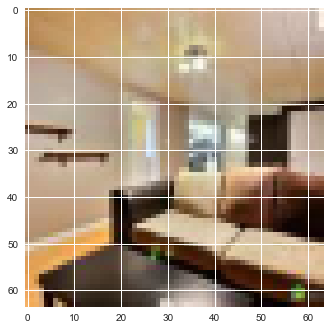

In [55]:
plt.imshow(md.trn_ds.denorm(x)[0])

In [96]:
#netG = DCGAN_G(sz,nz,3,64,1).cuda()
netG = DCGAN_G(sz,nz,3,64,1) # (self,isize,nz,nc,nfg,n_extra_layers=0):(100->3)反卷积，厚底变低，尺寸变大->图片生成
#netD = DCGAN_D(sz,3,64,1).cuda()
netD = DCGAN_D(sz,3,64,1) # (self,isize,nc,ndf,n_extra_layers=0):(3->64)卷积，厚度变高，尺寸变小->图片分类

In [99]:
def create_noise(b): return V(torch.zeros(b,nz,1,1).normal_(0,1)) # 随机正态分布(0,1), (bs*100*64*64)

C:\Users\ac32\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


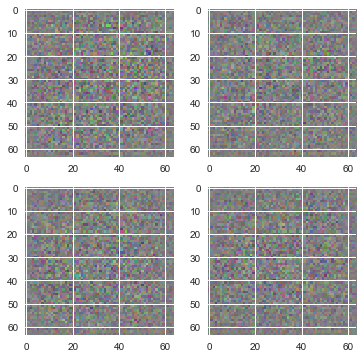

In [103]:
preds = netG(create_noise(4)) #输入一批4个噪音, (4*3*64*64)
pred_ims = md.trn_ds.denorm(preds) #因为输入都正则化，所以输出图片也要反正则化, (4*64*64*3)

fig,axes = plt.subplots(2,2,figsize=(6,6))
#fig,axes = plt.subplot((2,2),figsize=(6,6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

In [104]:
def gallery(x,nc=3):
    n,h,w,c = x.shape # 数量，高度，宽度，通道
    nr = n//nc
    assert n == nr*nc # 必须是3的整数倍
    return (x.reshape(nr,nc,h,w,c).swapaxes(1,2).reshape(h*nr,w*nc,c)) # 为什么要这样调整维度

In [105]:
optimizerD = optim.RMSprop(netD.parameters(),lr=1e-4) # 判别器的优化器
optimizerG = optim.RMSprop(netG.parameters(),lr=1e-4) # 生成器的优化器

In [108]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter): # 第几轮epoch
        netD.train(); netG.train() # 设置Module在训练模式下
        data_iter = iter(md.trn_dl) #训练数据dataloader迭代器，iter(iterable) -> iterator
        i,n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar: #进度条，每一轮中
            while i < n:
                set_trainable(netD, True) # model.parameters.requires_grad=True 判别器先训练
                set_trainable(netG, False) # 生成器先不训练
                # 判别器
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5 #
                j = 0
                while (j < d_iters) and (i < n): # 刚开始的时候，先训练判别器100 *25次，或者在每500次，后面稳定了训练5次
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01) # 参数在(-0.01,0.01)之间
                    real = V(next(data_iter)[0]) # 第一张真实图片组成的向量
                    real_loss = netD(real) # 真实图片作为判别器的输入，判别器对真图片的损失
                    fake = netG(create_noise(real.size(0))) # 一个噪音输入到生成器产生假照片
                    fake_loss = netD(V(fake.data)) # 假图片数据输入到判别器，判别器对假图片的损失
                    netD.zero_grad() # 设置判别器的参数的梯度到0
                    # 在同样的判别器模型下，对真图片判断为假产生损失，对假图片判断为真产生损失，两种损失是相反的，所以两种损失用减法
                    lossD = real_loss-fake_loss # 判别器的损失=真实图片的判断损失 +（-假图片的判断损失）
                    lossD.backward() # 根据损失后向传播计算梯度
                    optimizerD.step() # 完成一次参数更新，基于当前梯度和更新规则
                    pbar.update() # 训练进度更新
                
                set_trainable(netD, False) # 暂停判别器优化
                set_trainable(netG, True) # 开始开始生成器优化
                netG.zero_grad() # 生成器的参数的梯度为0
                lossG = netD(netG(create_noise(bs))).mean(0).view(1) # 一批噪音输入生成器，送入再鉴别器，作为生成器的损失
                lossG.backward() # 根据损失后向传播
                optimizerG.step() # 完成一次参数更新，基于当前梯度和更新规则
                gen_iterations += 1
            
        #print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
        #      f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')
        #print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; 'f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')
        print('Loss_D {}; Loss_G {}; '.format(to_np(lossD),to_np(lossG)), 'D_real {}; Loss_D_fake {}'.format(to_np(real_loss),to_np(fake_loss)))

In [109]:
torch.backends.cudnn.benchmark=True

In [110]:
train(1, False)

  0%|                                                 | 0/1895 [00:00<?, ?it/s]

C:\Users\ac32\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|████████████████████████████████████| 1895/1895 [5:12:23<00:00,  8.35s/it]
Loss_D [-0.74856]; Loss_G [0.21536];  D_real [-0.11576]; Loss_D_fake [0.6328]
100%|███████████████████████████████████████| 1/1 [5:12:27<00:00, 18747.35s/it]

In [113]:
fixed_noise = create_noise(bs) #bs=64

In [114]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [116]:
%time #魔法函数
train(1, False)

Wall time: 0 ns
  0%|                                                 | 0/1895 [00:00<?, ?it/s]

C:\Users\ac32\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


100%|████████████████████████████████████| 1895/1895 [5:14:04<00:00,  8.16s/it]
Loss_D [-1.30299]; Loss_G [0.67352];  D_real [-0.65156]; Loss_D_fake [0.65142]
100%|███████████████████████████████████████| 1/1 [5:14:07<00:00, 18847.61s/it]

WindowsPath('C:/input/Fast_AI/lsun_bedroom/sample/data0/lsun')

C:\Users\ac32\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


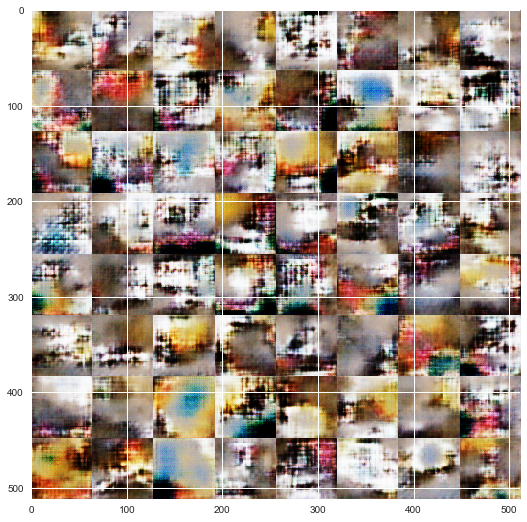

In [117]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

In [125]:
output = 'C:/input/Fast_AI/lsun_bedroom/sample/data0/lsun/tmp/'
#torch.save(netG.state_dict(), TMP_PATH/'netG_2.h5')
torch.save(netG.state_dict(), os.path.join(output, 'netG_2.h5'))
#torch.save(netD.state_dict(), TMP_PATH/'netD_2.h5')
torch.save(netD.state_dict(), os.path.join(output, 'netD_2.h5'))

In [ ]:
# done on 06/25/19 